In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps
import os
import sys
from pathlib import Path
from math import inf
from tqdm import tqdm

from torchvision.transforms import Compose, ToPILImage, ToTensor
import torch

top_folder = str(Path(os.getcwd()).parent.parent)
sys.path.append(top_folder)
%matplotlib widget

In [2]:
data_folder = os.path.join(top_folder, "data", "raw","unzipped","PanNuke")

In [3]:
images = np.load(os.path.join(data_folder, "images.npy"))

In [4]:
masks = np.load(os.path.join(data_folder, "masks.npy"))
masks.shape

(7901, 256, 256)

In [5]:
from src.transforms.he_normalize import normalize_he_image
from src.utilities.img_utilities import *


sample = images[:10]
normed = np.array([tensor_to_numpy(normalize_he_image(numpy_to_tensor(img))) for img in tqdm(sample, desc="Normalizing Images - PanNuke")])


Normalizing Images - PanNuke: 100%|██████████| 10/10 [00:00<00:00, 25.58it/s]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
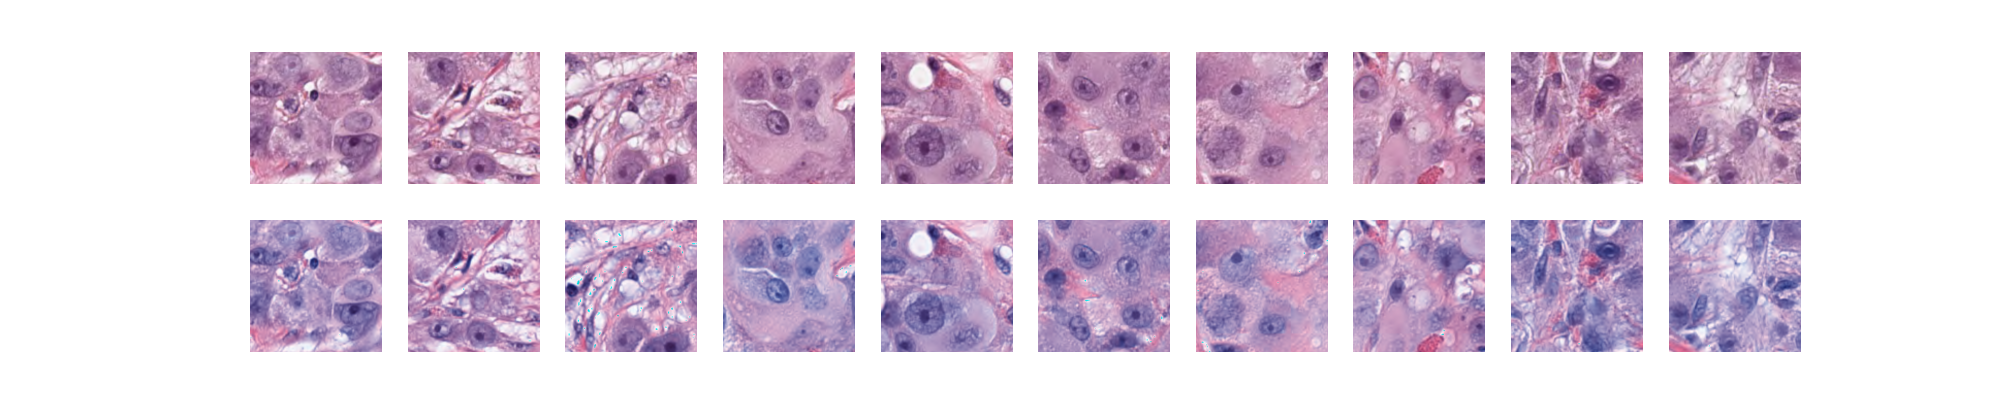

In [6]:
from src.vizualizations.image_viz import *

plot_images(np.concatenate([sample,normed],axis=0),(2,10))

195

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
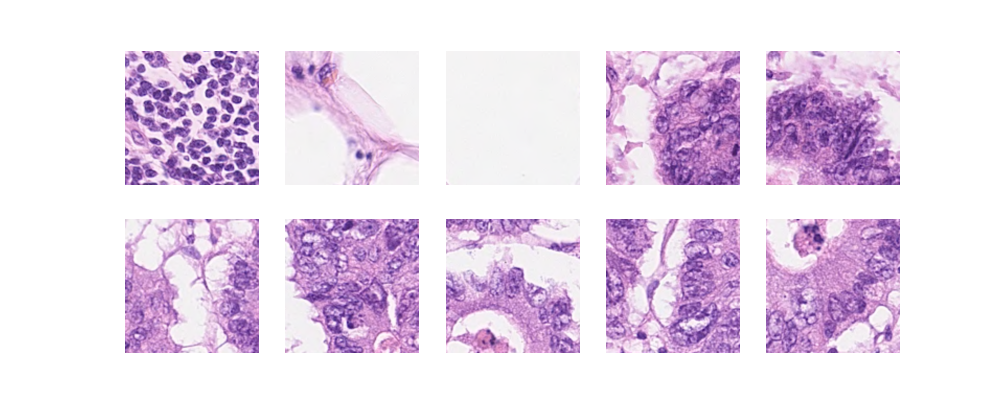

In [7]:
plot_images(images[760:770],(2,5)) # image 762 is bad
images[762].min()

# Problems with normalizing


In [8]:
from src.transforms.he_normalize import get_stain_vectors

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
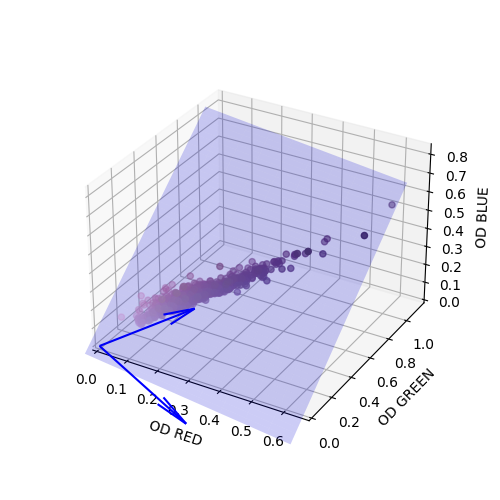

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
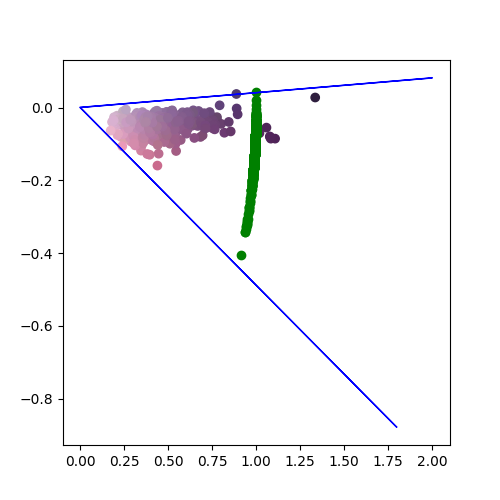

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
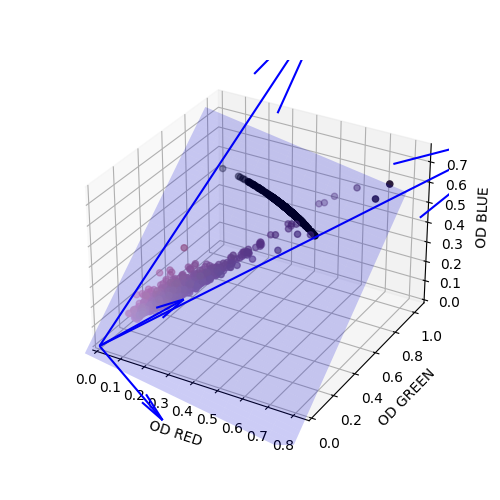

tensor([[0.5629, 0.7232, 0.4000],
        [0.1099, 0.8233, 0.5569]])

In [14]:
img = images[0]
get_stain_vectors(numpy_to_tensor(img),debug=True)

There is a serious issue with normalizing these images. In my opinion, it is because the images are 16 times smaller than the MoNuSeg ones. There is therefore little variation as it is also so zoomed in, and we are forced to compute the vectors on what is a very narrow tube.

I therefore will not be normalizing the PanNuke dataset.